# Weibull Analysis and ML for maintenance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reliability
from reliability.Fitters import Fit_Weibull_2P

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error   Lower CI    Upper CI
Parameter                                                       
Alpha           73.526074       16.329250  47.577304  113.627364
Beta             1.932678        0.648922   1.000824    3.732171
Log-Likelihood: -29.584921614901972 



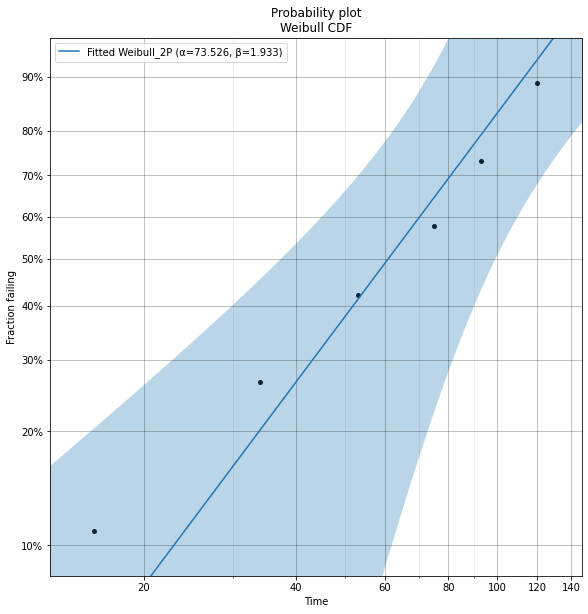

In [7]:
data = [16,34,53,75,93,120]
plt.figure(figsize=(12,8))
wb = Fit_Weibull_2P(failures=data)
plt.show()

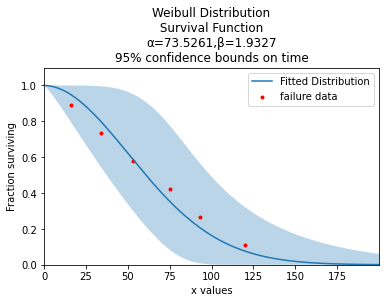

In [9]:
from reliability.Probability_plotting import plot_points
wb.distribution.SF(label='Fitted Distribution')
#plt.figure(figsize=(12,8))
plot_points(failures=data,func='SF',label='failure data',color='red')
plt.legend()
plt.show()

In [11]:
import sklearn
from sklearn.linear_model import LogisticRegression,LinearRegression

In [12]:
failure_time = [16,34,53,75,93,120,135,152]
cm_time = [12,6,8,24,11,12,5,8]
pm_time = [2.5,2,1,4,2,2.5,3,2.5]

lost_production_time = [3,4,3,8,2,3,7,1]

In [14]:
df = pd.DataFrame()
df['failure_time'] = failure_time
df['cm_time'] = cm_time
df['pm_time'] = pm_time
df['lost_production_time'] = lost_production_time
df.head()

,failure_time,cm_time,pm_time,lost_production_time
0,16,12,2.5,3
1,34,6,2.0,4
2,53,8,1.0,3
3,75,24,4.0,8
4,93,11,2.0,2


In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df[['failure_time','cm_time','pm_time']],df['lost_production_time'],test_size=0.1,random_state=0)

In [16]:
x_train

,failure_time,cm_time,pm_time
2,53,8,1.0
1,34,6,2.0
7,152,8,2.5
3,75,24,4.0
0,16,12,2.5
5,120,12,2.5
4,93,11,2.0


In [17]:
linear_model = LinearRegression()
linear_model.fit(x_train,y_train)

LinearRegression()

In [19]:
x_test

,failure_time,cm_time,pm_time
6,135,5,3.0


In [23]:
predictions_test = linear_model.predict(x_test)
predictions_test

array([0.94898747])

In [24]:
predictions_train = linear_model.predict(x_train)
predictions_train

array([2.44925383, 2.61291419, 1.25634039, 7.28213181, 4.66136443,
       2.85227558, 2.88571977])

In [29]:
predictions_df = pd.DataFrame(predictions_train)
predictions_df.columns=["pred"]
predictions_df

,pred
0,2.449254
1,2.612914
2,1.256340
3,7.282132
4,4.661364
5,2.852276
6,2.885720


In [44]:
df_plot = x_train[['failure_time','pm_time','cm_time']]
df_plot['pred'] = predictions_train
df_plot['y_train'] = y_train
df_plot.sort_index(inplace=True)
df_plot

,failure_time,pm_time,cm_time,pred,y_train
0,16,2.5,12,4.661364,3
1,34,2.0,6,2.612914,4
2,53,1.0,8,2.449254,3
3,75,4.0,24,7.282132,8
4,93,2.0,11,2.885720,2
5,120,2.5,12,2.852276,3
7,152,2.5,8,1.256340,1


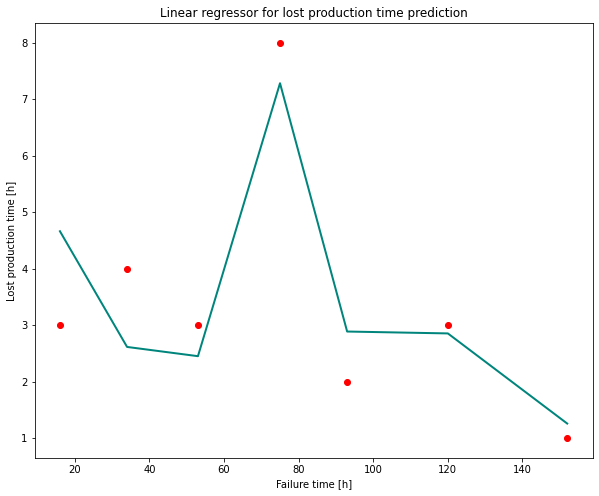

In [43]:
plt.figure(figsize=(10,8))
plt.scatter(df_plot['failure_time'],df_plot['y_train'],color='red')
plt.plot(df_plot['failure_time'],df_plot['pred'],color='#00857c',linewidth=2)
plt.title('Linear regressor for lost production time prediction')
plt.xlabel("Failure time [h]")
plt.ylabel("Lost production time [h]")
plt.show()

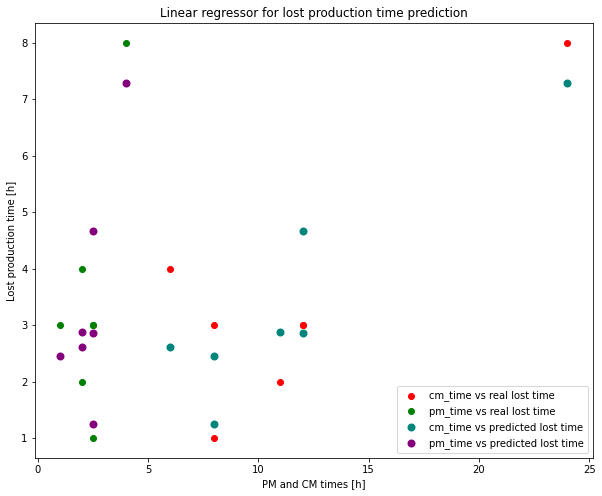

In [49]:
plt.figure(figsize=(10,8))
plt.scatter(df_plot['cm_time'],df_plot['y_train'],color='red')
plt.scatter(df_plot['pm_time'],df_plot['y_train'],color='green')
plt.scatter(df_plot['cm_time'],df_plot['pred'],color='#00857c',linewidth=2)
plt.scatter(df_plot['pm_time'],df_plot['pred'],color='#85007c',linewidth=2)
plt.legend(['cm_time vs real lost time','pm_time vs real lost time','cm_time vs predicted lost time','pm_time vs predicted lost time'])
plt.title('Linear regressor for lost production time prediction')
plt.xlabel("PM and CM times [h]")
plt.ylabel("Lost production time [h]")
plt.show()

In [51]:
df_mf = pd.read_csv("data/failure_machines_analysis.csv")
df_mf.head()

,time,M1_failure,M2_failure,M3_failure,M4_failure
0,3600,1,0,0,1
1,7200,1,1,0,1
2,10800,1,1,0,1
3,14400,1,1,1,1
4,18000,1,1,1,1


In [52]:
df_mf['time']=df_mf['time']/3600
df_mf.head()

,time,M1_failure,M2_failure,M3_failure,M4_failure
0,1.0,1,0,0,1
1,2.0,1,1,0,1
2,3.0,1,1,0,1
3,4.0,1,1,1,1
4,5.0,1,1,1,1


In [76]:
df_mf.shape[0]

479

In [119]:
def get_failure_times_M1(row):
    idx = row.name
    if row['M1_failure']==0 and idx < df_mf.shape[0]-1:
        if df_mf['M1_failure'].iloc[idx+1] == 1:
            return row['time']
        else:
            return 0
    else:
        return 0
def get_failure_times_M2(row):
    idx = row.name
    if row['M2_failure']==0 and idx < df_mf.shape[0]-1:
        if df_mf['M2_failure'].iloc[idx+1] == 1:
            return row['time']
        else:
            return 0
    else:
        return 0

def get_lost_time_M1(row):
    idx=row.name
    j=0
    total_time = 0
    if row['M1_failure']==0 and idx < df_mf.shape[0]-1:
        if df_mf['M1_failure'].iloc[idx+1] == 1:
            while df_mf['M1_failure'].iloc[idx+j+1]==1:
                if (idx+j+2) >= df_mf.shape[0]:
                    break
                total_time = total_time + 1
                j=j+1
            j=0                
            return total_time
        else:
            return 0
    else:
        return 0
def get_lost_time_M2(row):
    idx=row.name
    j=0
    total_time = 0
    if row['M2_failure']==0 and idx < df_mf.shape[0]-1:
        if df_mf['M2_failure'].iloc[idx+1] == 1:
            while df_mf['M2_failure'].iloc[idx+j+1]==1:
                if (idx+j+2) >= df_mf.shape[0]:
                    break
                total_time = total_time + 1
                j=j+1
            j=0                
            return total_time
        else:
            return 0
    else:
        return 0      

In [106]:
df_time_M1 = df_mf.apply(get_lost_time_M1,axis=1)
df_time_M1[df_time_M1>0]

24      4
29      4
35     11
69      4
76      4
       ..
450     2
456     4
461     3
465     3
469     8
Length: 62, dtype: int64

In [107]:
df_transf_M1 = df_mf.apply(get_failure_times_M1,axis=1)
df_transf_M1[df_transf_M1>0]

24      25.0
29      30.0
35      36.0
69      70.0
76      77.0
       ...  
450    451.0
456    457.0
461    462.0
465    466.0
469    470.0
Length: 62, dtype: float64

In [108]:
df_M1 = pd.DataFrame()
df_M1['failure_time'] = df_transf_M1[df_transf_M1>0].values
df_M1['lost_production_time'] = df_time_M1[df_time_M1>0].values
df_M1.head()

,failure_time,lost_production_time
0,25.0,4
1,30.0,4
2,36.0,11
3,70.0,4
4,77.0,4


In [117]:
df_time_M2 = df_mf.apply(get_lost_time_M2,axis=1)
df_time_M2[df_time_M2>0]

0      12
20      4
26      3
33      6
41      6
       ..
411     1
415    12
429     8
440    12
472     2
Length: 66, dtype: int64

In [120]:
df_transf_M2 = df_mf.apply(get_failure_times_M2,axis=1)
df_transf_M2[df_transf_M2>0]

0        1.0
20      21.0
26      27.0
33      34.0
41      42.0
       ...  
411    412.0
415    416.0
429    430.0
440    441.0
472    473.0
Length: 66, dtype: float64

In [121]:
df_M2 = pd.DataFrame()
df_M2['failure_time'] = df_transf_M2[df_transf_M2>0].values
df_M2['lost_production_time'] = df_time_M2[df_time_M2>0].values
df_M2.head()

,failure_time,lost_production_time
0,1.0,12
1,21.0,4
2,27.0,3
3,34.0,6
4,42.0,6


In [122]:
df_M1.shape

(62, 2)

In [123]:
df_M2.shape

(66, 2)

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error    Lower CI    Upper CI
Parameter                                                        
Alpha          290.332431       18.628731  256.023317  329.239233
Beta             2.073059        0.219560    1.684457    2.551312
Log-Likelihood: -388.5136839602022 



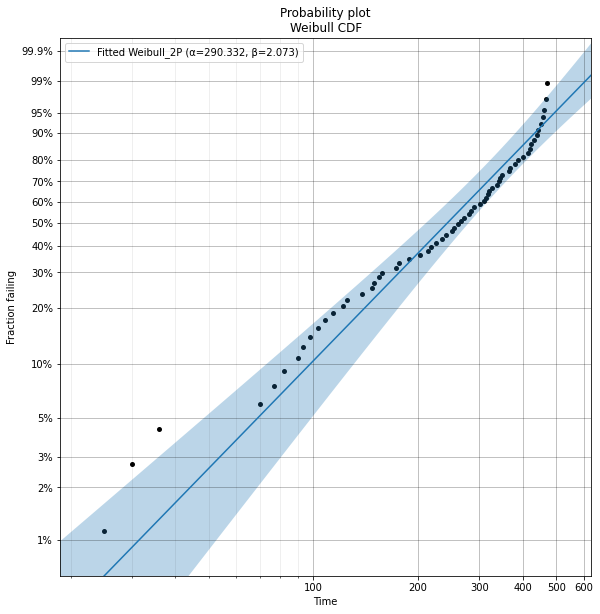

In [124]:
plt.figure(figsize=(12,8))
wb_M1 = Fit_Weibull_2P(failures=df_M1['failure_time'].values)
plt.show()

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error    Lower CI    Upper CI
Parameter                                                        
Alpha          245.810173       18.943512  211.349625  285.889511
Beta             1.667331        0.171857    1.362342    2.040599
Log-Likelihood: -412.52757627686026 



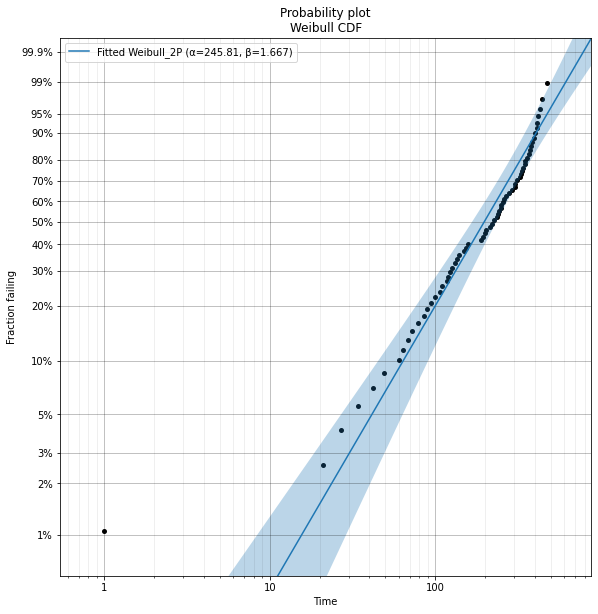

In [125]:
plt.figure(figsize=(12,8))
wb_M2 = Fit_Weibull_2P(failures=df_M2['failure_time'].values)
plt.show()

In [148]:
x_train_M1,x_test_M1,y_train_M1,y_test_M1 = train_test_split(df_M1[['failure_time']],df_M1['lost_production_time'],test_size=0.25)
x_train_M2,x_test_M2,y_train_M2,y_test_M2 = train_test_split(df_M2[['failure_time']],df_M2['lost_production_time'],test_size=0.25)

In [149]:
lr_M1 = LinearRegression()
lr_M1.fit(x_train_M1,y_train_M1)
predictions_test_M1 = lr_M1.predict(x_test_M1)
predictions_test_M1

array([3.84020184, 3.85148671, 3.78716292, 3.85289732, 3.80860419,
       3.81565723, 3.83709849, 3.84386942, 3.84866549, 3.75951498,
       3.80775782, 3.77192834, 3.76261832, 3.77616017, 3.79731931,
       3.8345594 ])

In [150]:
lr_M2 = LinearRegression()
lr_M2.fit(x_train_M2,y_train_M2)
predictions_test_M2 = lr_M2.predict(x_test_M2)
predictions_test_M2

array([3.75246887, 3.69145883, 3.69633963, 3.66969858, 3.68698476,
       3.68495109, 3.70244064, 3.74026686, 3.73192882, 3.74128369,
       3.73518269, 3.72074365, 3.75511263, 3.70630461, 3.74941836,
       3.69369586, 3.68332416])

In [163]:
x_test_M1['failure_time'].values

array([138.,  98., 326.,  93., 250., 225., 149., 125., 108., 424., 253.,
       380., 413., 365., 290., 158.])

In [165]:
df_plot_M1_lr =pd.DataFrame()
df_plot_M1_lr['failure_time'] = x_test_M1['failure_time'].values
df_plot_M1_lr['pred'] = predictions_test_M1
df_plot_M1_lr.sort_values(by=['failure_time'],inplace=True)
df_plot_M1_lr

,failure_time,pred
3,93.0,3.852897
1,98.0,3.851487
8,108.0,3.848665
7,125.0,3.843869
0,138.0,3.840202
6,149.0,3.837098
15,158.0,3.834559
5,225.0,3.815657
4,250.0,3.808604
10,253.0,3.807758


In [166]:
df_plot_M2_lr =pd.DataFrame()
df_plot_M2_lr['failure_time'] = x_test_M2['failure_time'].values
df_plot_M2_lr['pred'] = predictions_test_M2
df_plot_M2_lr.sort_values(by=['failure_time'],inplace=True)
df_plot_M2_lr

,failure_time,pred
12,21.0,3.755113
0,34.0,3.752469
14,49.0,3.749418
9,89.0,3.741284
7,94.0,3.740267
10,119.0,3.735183
8,135.0,3.731929
11,190.0,3.720744
13,261.0,3.706305
6,280.0,3.702441


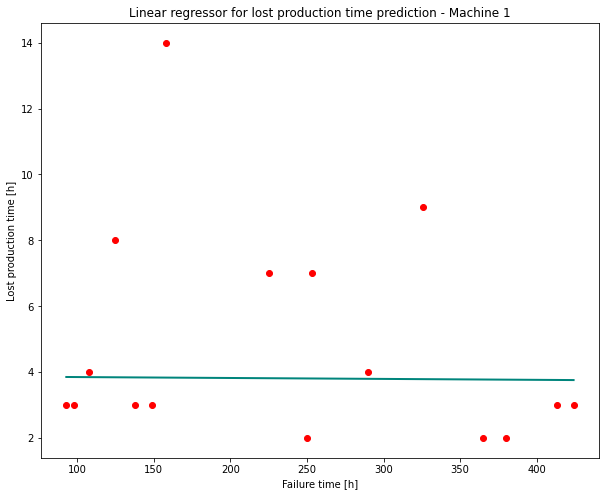

In [168]:
plt.figure(figsize=(10,8))
plt.scatter(x_test_M1,y_test_M1,color='red')
plt.plot(df_plot_M1_lr['failure_time'],df_plot_M1_lr['pred'],color='#00857c',linewidth=2)
plt.title('Linear regressor for lost production time prediction - Machine 1')
plt.xlabel("Failure time [h]")
plt.ylabel("Lost production time [h]")
plt.show()

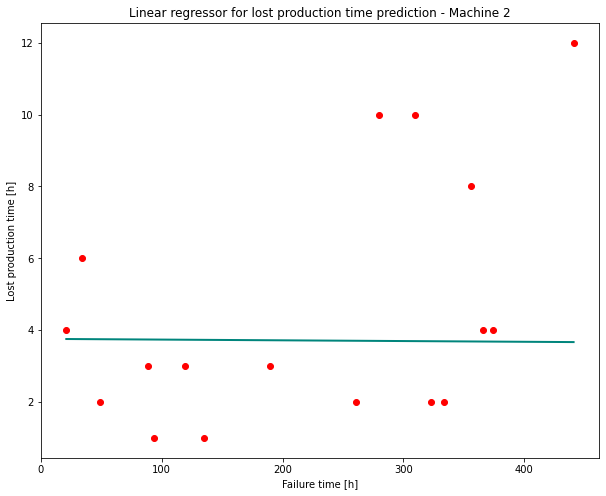

In [169]:
plt.figure(figsize=(10,8))
plt.scatter(x_test_M2,y_test_M2,color='red')
plt.plot(df_plot_M2_lr['failure_time'],df_plot_M2_lr['pred'],color='#00857c',linewidth=2)
plt.title('Linear regressor for lost production time prediction - Machine 2')
plt.xlabel("Failure time [h]")
plt.ylabel("Lost production time [h]")
plt.show()

In [153]:
from sklearn.ensemble import RandomForestRegressor

In [154]:
rf_M1 = RandomForestRegressor()
rf_M1.fit(x_train_M1,y_train_M1)
rf_predictions_test_M1 = rf_M1.predict(x_test_M1)
rf_predictions_test_M1

array([ 1.4 ,  1.43,  2.61,  1.43,  6.97,  2.07,  1.29,  2.2 ,  1.81,
        2.42,  5.09,  4.43,  2.5 , 10.14,  3.52,  1.73])

In [155]:
rf_M2 = RandomForestRegressor()
rf_M2.fit(x_train_M2,y_train_M2)
rf_predictions_test_M2 = rf_M2.predict(x_test_M2)
rf_predictions_test_M2

array([3.82, 2.94, 4.31, 7.93, 2.15, 4.24, 6.96, 4.  , 2.12, 3.52, 1.55,
       2.8 , 6.09, 3.95, 4.74, 3.2 , 4.29])

In [173]:
df_plot_M1_rf =pd.DataFrame()
df_plot_M1_rf['failure_time'] = x_test_M1['failure_time'].values
df_plot_M1_rf['pred'] = rf_predictions_test_M1
df_plot_M1_rf.sort_values(by=['failure_time'],inplace=True)
df_plot_M1_rf

,failure_time,pred
3,93.0,1.43
1,98.0,1.43
8,108.0,1.81
7,125.0,2.20
0,138.0,1.40
6,149.0,1.29
15,158.0,1.73
5,225.0,2.07
4,250.0,6.97
10,253.0,5.09


In [174]:
df_plot_M2_rf =pd.DataFrame()
df_plot_M2_rf['failure_time'] = x_test_M2['failure_time'].values
df_plot_M2_rf['pred'] = rf_predictions_test_M2
df_plot_M2_rf.sort_values(by=['failure_time'],inplace=True)
df_plot_M2_rf

,failure_time,pred
12,21.0,6.09
0,34.0,3.82
14,49.0,4.74
9,89.0,3.52
7,94.0,4.00
10,119.0,1.55
8,135.0,2.12
11,190.0,2.80
13,261.0,3.95
6,280.0,6.96


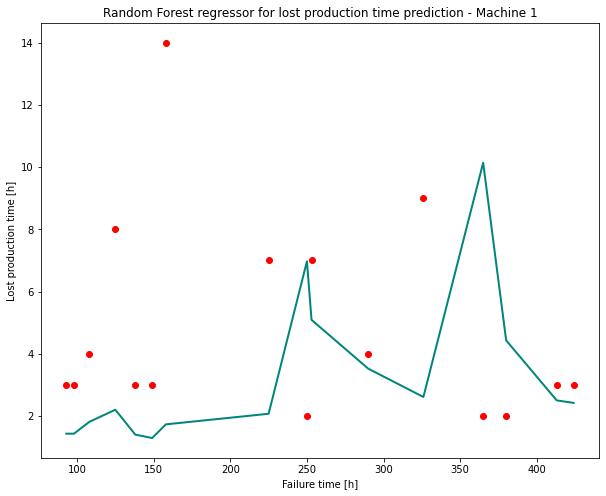

In [175]:
plt.figure(figsize=(10,8))
plt.scatter(x_test_M1,y_test_M1,color='red')
plt.plot(df_plot_M1_rf['failure_time'],df_plot_M1_rf['pred'],color='#00857c',linewidth=2)
plt.title('Random Forest regressor for lost production time prediction - Machine 1')
plt.xlabel("Failure time [h]")
plt.ylabel("Lost production time [h]")
plt.show()

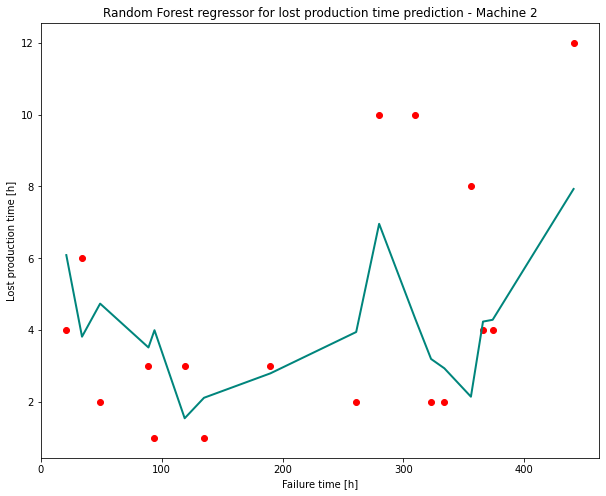

In [176]:
plt.figure(figsize=(10,8))
plt.scatter(x_test_M2,y_test_M2,color='red')
plt.plot(df_plot_M2_rf['failure_time'],df_plot_M2_rf['pred'],color='#00857c',linewidth=2)
plt.title('Random Forest regressor for lost production time prediction - Machine 2')
plt.xlabel("Failure time [h]")
plt.ylabel("Lost production time [h]")
plt.show()